# Analysis 1
- Outcome: EAC 
- Model: CoxPH 
- Feature selection: Significant variables based on univariate analysis
- Predicts 5 year risk for EAC
- Risk score threshold determined on 1) 4th quartile and 2) optimal threshold 
- Drop patients with missing sex 

## Import libraries

In [71]:
%load_ext rpy2.ipython 
# Load the R magic extension

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path

In [73]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [74]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [75]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

In [76]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [77]:
%%R 
r_df_normal <- read.csv("df_analysis0.csv")

In [78]:
univariate_filename = './../results/univariate_analysis_1_eac.csv'
multivariate_filename = './../results/multivariate_analysis_1_eac.csv'

In [79]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean']
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis

In [80]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening"
)

### Factorize categorical vars and set reference levels

In [81]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [82]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex"                           "sex_missing"                  
 [3] "race_clean"                    "race_clean_missing"           
 [5] "ethnicity"                     "ethnicity_missing"            
 [7] "alcohol_all"                   "alcohol_binary"               
 [9] "tobacco_all"                   "tobacco_all_missing"          
[11] "tobacco_binary"                "tobacco_binary_missing"       
[13] "hpylori_active"                "hpylori_active_chronic"       
[15] "hpylori_active_chronic_binary" "hnca"                         
[17] "achalasia"                     "pud"                          
[19] "gerd"                          "cad"                          
[21] "barretts"                      "famhx_cancer"                 
[23] "famhx_esophagealca"            "famhx_gastricca"              
[25] "famhx_colonca"                 "famhx_barretts"               
[27] "ASA"                           "PPI"                          
[29] "NSAID"                      

In [83]:
%%R
# TODO Manually edit me

vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("Surv(months_to_event, ugica_EAC) ~", i))
    
    model <- coxph(formula, data=r_df_normal)

    model_summary <- summary(model)
    coef <- exp(model_summary$coef[, "coef"])
    confint_vals <- exp(confint(model))
    p_value <- model_summary$coef[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(model_summary$coef)

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        HR = coef,
        CI_lower = confint_vals[, 1],
        CI_upper = confint_vals[, 2],
        p_value = p_value
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

In [84]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [85]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,HR,CI_lower,CI_upper,p_value
0,sex.sexMALE,sex,MALE,6.568008,3.140605,13.735803,5.729441e-07
2,sex_missing,sex_missing,MALE,6.568008,3.140605,13.735803,5.729441e-07
4,race_clean.race_cleanBlack or African American,race_clean,Black or African American,0.194116,0.077206,0.488060,4.924151e-04
5,race_clean.race_cleanNo matching concept,race_clean,No matching concept,0.423571,0.240187,0.746969,2.998790e-03
8,race_clean_missing.race_clean_missingBlack or ...,race_clean_missing,Black or African American,0.193848,0.077099,0.487386,4.870449e-04
32,gerd,gerd,1,2.057079,1.208627,3.501142,7.853308e-03
34,barretts,barretts,1,28.118817,15.594757,50.700875,1.358401e-28
35,famhx_cancer,famhx_cancer,1,2.780153,1.720624,4.492121,2.957274e-05
36,famhx_gastricca,famhx_gastricca,1,4.496102,1.637009,12.348700,3.544526e-03
38,ASA,ASA,1,0.358864,0.144267,0.892671,2.751313e-02


## Feature selection

In [141]:
%%R 
# TODO Manually edit me

selected_vars <- final_results %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% c("sex", "race_clean_missing", 'hgball_baseline_imputed_mean') & 
    !selected_vars %in% cols_to_ignore]
selected_vars

[1] "sex_missing"     "race_clean"      "gerd"            "barretts"       
[5] "famhx_cancer"    "famhx_gastricca" "ASA"             "PPI"            
[9] "weight_baseline"


## CoxPH multivariate model training

In [142]:
%%R 
# TODO Manually edit me

library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica_EAC, all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica_EAC, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica_EAC' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica_EAC)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica_EAC)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica_EAC)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = coxph) {
  formula_str <- paste("Surv(months_to_event, ugica_EAC) ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(cox_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    cox_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      HR_scaled = estimate / min(estimate, na.rm = TRUE),
      HR_rank = round(HR_scaled)
  ) 

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set$ugica_EAC == 1)
  
  list(risk = risk, event = event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


In [143]:
%%R 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
cox_model <- train_model(train_set, selected_vars, model_func=coxph)

# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(cox_model, "multivariate_results.csv", variable_labels)


[1] "Dataset Controls 20212" "Dataset Cases 39"      
[1] "Training Controls 16172" "Training Cases 29"      
[1] "Validation Controls 4040" "Validation Cases 10"     

Multivariate results saved to multivariate_results.csv 


In [144]:
%%R 
# TODO Manually edit me

# Estimate risk
risk_result <- calculate_risk(cox_model, validation_set)
risk_5_years <- risk_result$risk
event_5_years <- risk_result$event

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event = validation_set$ugica_EAC,
    pred_risk = risk_5_years,
    actual_event = event_5_years
)

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.906 
Sensitivity: 1 
Specificity: 0.7008653 
PPV: 0.004115226 
NPV: 1 
NNS: 243 
     predicted_class
event    0    1
    0 2835 1210
    1    0    5


In [145]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.906 
Sensitivity: 1 
Specificity: 0.8081582 
PPV: 0.006402049 
NPV: 1 
NNS: 156.2 
     predicted_class
event    0    1
    0 3269  776
    1    0    5


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



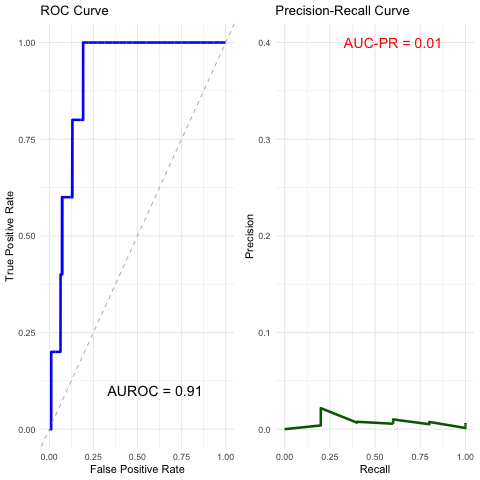

In [146]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)

# Show all plots in a grid (KM comes with table, so best shown separately)
grid.arrange(p1, p2, nrow=1)  # ROC and PR side-by-side

In [147]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]

print(df_validation_risk.actual_event.value_counts()) # Cases differ from ugica because the event needs to occur within the time frame of 5 years
df_validation_risk['risk_quartile'] = pd.qcut(df_validation_risk['pred_risk'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
df_validation_risk['low_risk'] = np.where(df_validation_risk.risk_quartile == 'Q1', 1, 0)
df_validation_risk['high_risk'] = np.where(df_validation_risk.risk_quartile == 'Q4', 1, 0)
df_validation_risk['risk_q1'] = np.where(df_validation_risk.risk_quartile.isin(['Q1']), 0, 1)
df_validation_risk['risk_q2'] = np.where(df_validation_risk.risk_quartile.isin(['Q1', 'Q2']), 0, 1)
df_validation_risk['risk_q3'] = np.where(df_validation_risk.risk_quartile.isin(['Q1', 'Q2', 'Q3']), 0, 1)
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk.pred_risk >= optimal_threshold, 1, 0)



actual_event
0.0    4045
1.0       5
Name: count, dtype: int64


In [148]:
df_validation_risk.head()

,time,event,pred_risk,actual_event,risk_quartile,low_risk,high_risk,risk_q1,risk_q2,risk_q3,high_risk_youden
3,7.852156,0,2.154343e-11,0.0,Q1,1,0,0,0,0,0
8,1.806982,0,3.622119e-03,0.0,Q4,0,1,1,1,1,0
12,0.164271,0,8.755601e-03,0.0,Q4,0,1,1,1,1,1
24,37.388090,0,3.282345e-03,0.0,Q3,0,0,1,1,0,0
34,24.870637,0,3.412165e-04,0.0,Q1,1,0,0,0,0,0


In [149]:
pd.crosstab(df_validation_risk.actual_event, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
actual_event,,
0.0,3269,776
1.0,0,5


In [150]:
pd.crosstab(df_validation_risk.actual_event, df_validation_risk.high_risk)

high_risk,0,1
actual_event,,
0.0,3037,1008
1.0,0,5


In [151]:
# Pass dataframe to R to analyze
pass_df(df_validation_risk, 'r_df_validation_risk')
df_validation_risk.head()

,time,event,pred_risk,actual_event,risk_quartile,low_risk,high_risk,risk_q1,risk_q2,risk_q3,high_risk_youden
3,7.852156,0,2.154343e-11,0.0,Q1,1,0,0,0,0,0
8,1.806982,0,3.622119e-03,0.0,Q4,0,1,1,1,1,0
12,0.164271,0,8.755601e-03,0.0,Q4,0,1,1,1,1,1
24,37.388090,0,3.282345e-03,0.0,Q3,0,0,1,1,0,0
34,24.870637,0,3.412165e-04,0.0,Q1,1,0,0,0,0,0


In [152]:
def classification_metrics(risk_group, predicted_class, actual_class):
    # Get confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    # Return as dictionary
    return {
        "risk_group": risk_group,
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [153]:
risk_groups = ['risk_q1', 'risk_q2', 'risk_q3']
results_by_riskgroup = []

for risk_group in risk_groups:
    row = classification_metrics(risk_group, df_validation_risk[risk_group], df_validation_risk.actual_event)
    results_by_riskgroup.append(row)

In [154]:
pd.DataFrame(results_by_riskgroup)

,risk_group,sensitivity,specificity,ppv,npv,youden_index
0,risk_q1,100.0,25.043263,0.164636,100.0,0.250433
1,risk_q2,100.0,50.061805,0.246914,100.0,0.500618
2,risk_q3,100.0,75.080346,0.493583,100.0,0.750803


/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_69262/1730954205.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_quartile')['actual_event'].mean()*100).reset_index().rename(columns = {'actual_event': 'prevalence'})


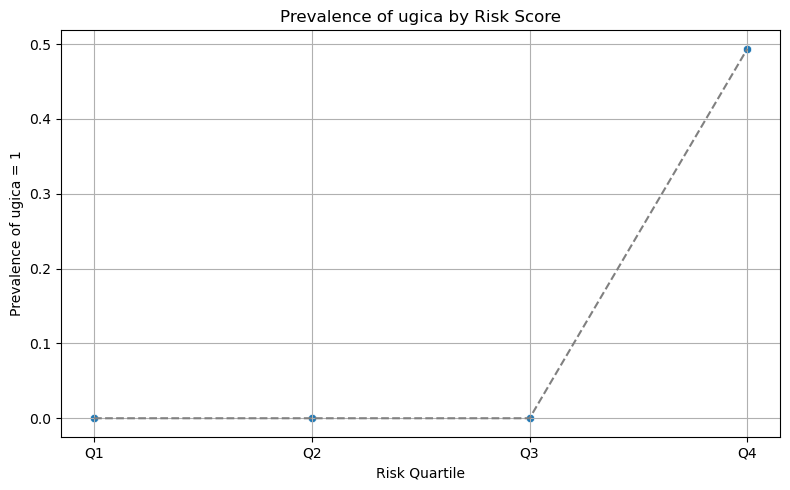

In [155]:
# Group by risk_score and calculate prevalence of ugica == 1
prevalence_df = (df_validation_risk.groupby('risk_quartile')['actual_event'].mean()*100).reset_index().rename(columns = {'actual_event': 'prevalence'})

# Plot the scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=prevalence_df, x='risk_quartile', y='prevalence')

# Optionally add a line to show trend
sns.lineplot(data=prevalence_df, x='risk_quartile', y='prevalence', color='gray', linestyle='--')

plt.xlabel("Risk Quartile")
plt.ylabel("Prevalence of ugica = 1")
plt.title("Prevalence of ugica by Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()


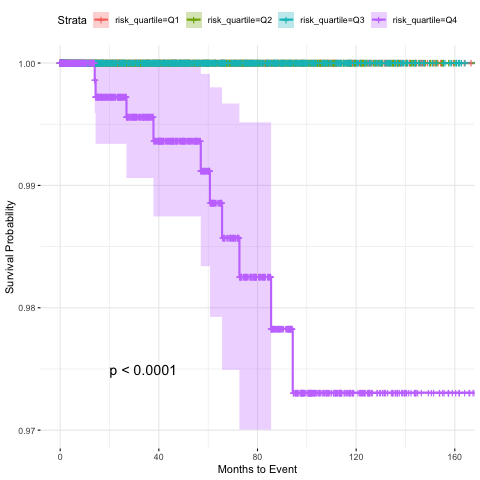

In [156]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event)
fit <- survfit(surv_obj ~ risk_quartile, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.975),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.97, 1),
    ggtheme = theme_minimal()
)

g$plot

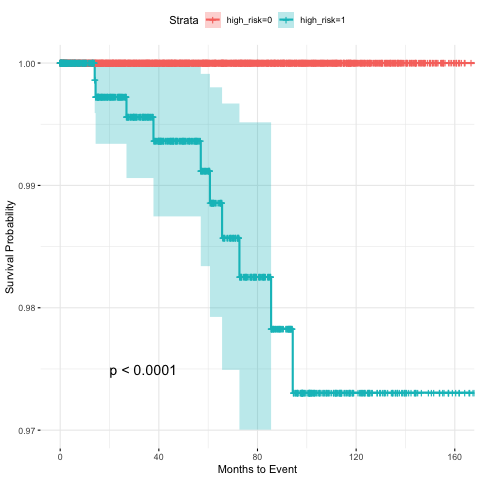

In [157]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event)
fit <- survfit(surv_obj ~ high_risk, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.975),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.97, 1),
    ggtheme = theme_minimal()
)

g$plot

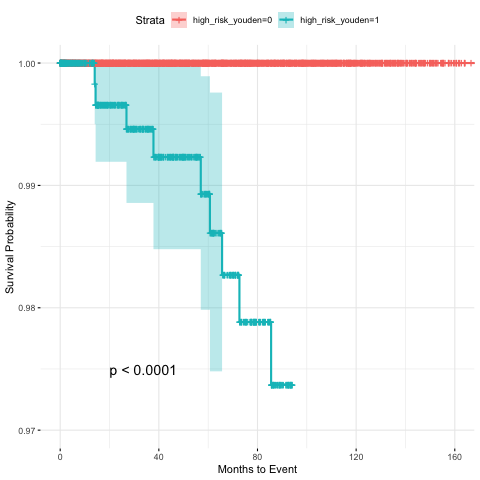

In [158]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.975),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.970, 1),
    ggtheme = theme_minimal()
)

g$plot